# Complete Crater Detection and Ellipse Fitting Pipeline
## Fixed version with proper bbox-ellipse alignment

### Step 1: YOLO Detection with Custom Data Storage

In [1]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from pathlib import Path
import json

# =========================
# CONFIGURATION
# =========================
MODEL_PATH = r"D:\datashare\ModelTraining\Model\weights\best.pt"
SOURCE_IMAGE = r"D:\datashare\test\test\altitude01\longitude05\orientation01_light02.png"
OUTPUT_BASE = r"D:\datashare\crater_detection_output"

# Create output directory structure
image_name = Path(SOURCE_IMAGE).stem
output_dir = os.path.join(OUTPUT_BASE, image_name)
crops_dir = os.path.join(output_dir, "crops")
results_dir = os.path.join(output_dir, "results")

os.makedirs(crops_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print(f"Output directory: {output_dir}")

Output directory: D:\datashare\crater_detection_output\orientation01_light02


### Step 2: Run YOLO Detection and Save with Metadata

In [2]:
# Load YOLO model
model = YOLO(MODEL_PATH)

# Load original image
original_img = cv2.imread(SOURCE_IMAGE)
img_height, img_width = original_img.shape[:2]
print(f"Image size: {img_width} x {img_height}")

# Run prediction
results = model.predict(
    source=SOURCE_IMAGE,
    imgsz=640,
    conf=0.25,
    iou=0.5,
    device="cpu",
    save=False,  # We'll save manually
    verbose=True
)

# Extract detection information
detections = []
result = results[0]  # Get first result (single image)

if result.boxes is not None:
    boxes = result.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
    confidences = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    
    for idx, (box, conf, cls) in enumerate(zip(boxes, confidences, classes)):
        x1, y1, x2, y2 = map(int, box)
        
        # Crop the detection
        crop = original_img[y1:y2, x1:x2].copy()
        
        # Save crop
        crop_filename = f"crater_{idx:03d}.jpg"
        crop_path = os.path.join(crops_dir, crop_filename)
        cv2.imwrite(crop_path, crop)
        
        # Store detection metadata
        detections.append({
            'id': idx,
            'crop_file': crop_filename,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'width': x2 - x1,
            'height': y2 - y1,
            'confidence': float(conf),
            'class': int(cls)
        })
        
print(f"Detected {len(detections)} craters")

# Save detections metadata
metadata_path = os.path.join(results_dir, "detections.json")
with open(metadata_path, 'w') as f:
    json.dump(detections, f, indent=2)

print(f"Saved detections metadata to: {metadata_path}")

Image size: 2592 x 2048

image 1/1 D:\datashare\test\test\altitude01\longitude05\orientation01_light02.png: 512x640 38 craters, 560.6ms
Speed: 11.8ms preprocess, 560.6ms inference, 15.9ms postprocess per image at shape (1, 3, 512, 640)
Detected 38 craters
Saved detections metadata to: D:\datashare\crater_detection_output\orientation01_light02\results\detections.json


### Step 3: Fit Ellipses to Each Crop

In [3]:
import csv

# Create CSV for ellipse parameters
ellipse_csv_path = os.path.join(results_dir, "ellipse_params.csv")

with open(ellipse_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'crater_id',
        'crop_file',
        'center_x_crop',
        'center_y_crop',
        'semi_major',
        'semi_minor',
        'angle_deg',
        'bbox_x1',
        'bbox_y1',
        'bbox_x2',
        'bbox_y2'
    ])

ellipse_data = []
successful_fits = 0

for detection in detections:
    crop_path = os.path.join(crops_dir, detection['crop_file'])
    crop_img = cv2.imread(crop_path, cv2.IMREAD_GRAYSCALE)
    
    if crop_img is None:
        print(f"Failed to load: {detection['crop_file']}")
        continue
    
    try:
        # ---------- PREPROCESS ----------
        blur = cv2.GaussianBlur(crop_img, (7, 7), 0)
        clahe = cv2.createCLAHE(3.0, (8, 8))
        enhanced = clahe.apply(blur)
        
        # ---------- EDGE DETECTION ----------
        edges = cv2.Canny(enhanced, 50, 140)
        
        # Remove crop borders (10 pixels)
        border = 10
        edges[:border, :] = 0
        edges[-border:, :] = 0
        edges[:, :border] = 0
        edges[:, -border:] = 0
        
        # ---------- DISTANCE TRANSFORM ----------
        inv = cv2.bitwise_not(edges)
        dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
        dist = cv2.normalize(dist, None, 0, 1, cv2.NORM_MINMAX)
        
        # Find rim points (close to edge)
        rim_mask = (dist < 0.12).astype(np.uint8) * 255
        
        # ---------- COLLECT RIM POINTS ----------
        ys, xs = np.where(rim_mask > 0)
        points = np.column_stack((xs, ys))
        
        if len(points) < 30:
            print(f"Skipping {detection['crop_file']}: insufficient rim points ({len(points)})")
            continue
        
        points = points.reshape(-1, 1, 2).astype(np.int32)
        
        # ---------- FIT ELLIPSE ----------
        ellipse = cv2.fitEllipse(points)
        (cx, cy), (W, H), angle = ellipse
        
        # Semi-axes
        semi_major = max(W, H) / 2.0
        semi_minor = min(W, H) / 2.0
        
        # Store ellipse data with bbox info
        ellipse_entry = {
            'crater_id': detection['id'],
            'crop_file': detection['crop_file'],
            'center_x_crop': cx,
            'center_y_crop': cy,
            'semi_major': semi_major,
            'semi_minor': semi_minor,
            'angle_deg': angle,
            'bbox_x1': detection['x1'],
            'bbox_y1': detection['y1'],
            'bbox_x2': detection['x2'],
            'bbox_y2': detection['y2']
        }
        
        ellipse_data.append(ellipse_entry)
        
        # Write to CSV
        with open(ellipse_csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                ellipse_entry['crater_id'],
                ellipse_entry['crop_file'],
                round(cx, 2),
                round(cy, 2),
                round(semi_major, 2),
                round(semi_minor, 2),
                round(angle, 2),
                detection['x1'],
                detection['y1'],
                detection['x2'],
                detection['y2']
            ])
        
        successful_fits += 1
        print(f"✓ Fitted ellipse for {detection['crop_file']}")
        
    except Exception as e:
        print(f"✗ Error fitting ellipse for {detection['crop_file']}: {e}")
        continue

print(f"\nSuccessfully fitted {successful_fits}/{len(detections)} ellipses")
print(f"Ellipse parameters saved to: {ellipse_csv_path}")

✓ Fitted ellipse for crater_000.jpg
✓ Fitted ellipse for crater_001.jpg
✓ Fitted ellipse for crater_002.jpg
✓ Fitted ellipse for crater_003.jpg
✓ Fitted ellipse for crater_004.jpg
✓ Fitted ellipse for crater_005.jpg
✓ Fitted ellipse for crater_006.jpg
✓ Fitted ellipse for crater_007.jpg
✓ Fitted ellipse for crater_008.jpg
✓ Fitted ellipse for crater_009.jpg
✓ Fitted ellipse for crater_010.jpg
✓ Fitted ellipse for crater_011.jpg
✓ Fitted ellipse for crater_012.jpg
✓ Fitted ellipse for crater_013.jpg
✓ Fitted ellipse for crater_014.jpg
✓ Fitted ellipse for crater_015.jpg
✓ Fitted ellipse for crater_016.jpg
✓ Fitted ellipse for crater_017.jpg
✓ Fitted ellipse for crater_018.jpg
✓ Fitted ellipse for crater_019.jpg
✓ Fitted ellipse for crater_020.jpg
✓ Fitted ellipse for crater_021.jpg
✓ Fitted ellipse for crater_022.jpg
✓ Fitted ellipse for crater_023.jpg
✓ Fitted ellipse for crater_024.jpg
✓ Fitted ellipse for crater_025.jpg
✓ Fitted ellipse for crater_026.jpg
✓ Fitted ellipse for crater_

### Step 4: Draw All Ellipses on Original Image

Loaded 38 ellipse parameters

Final overlay saved to: D:\datashare\crater_detection_output\orientation01_light02\results\final_ellipses_overlay.jpg


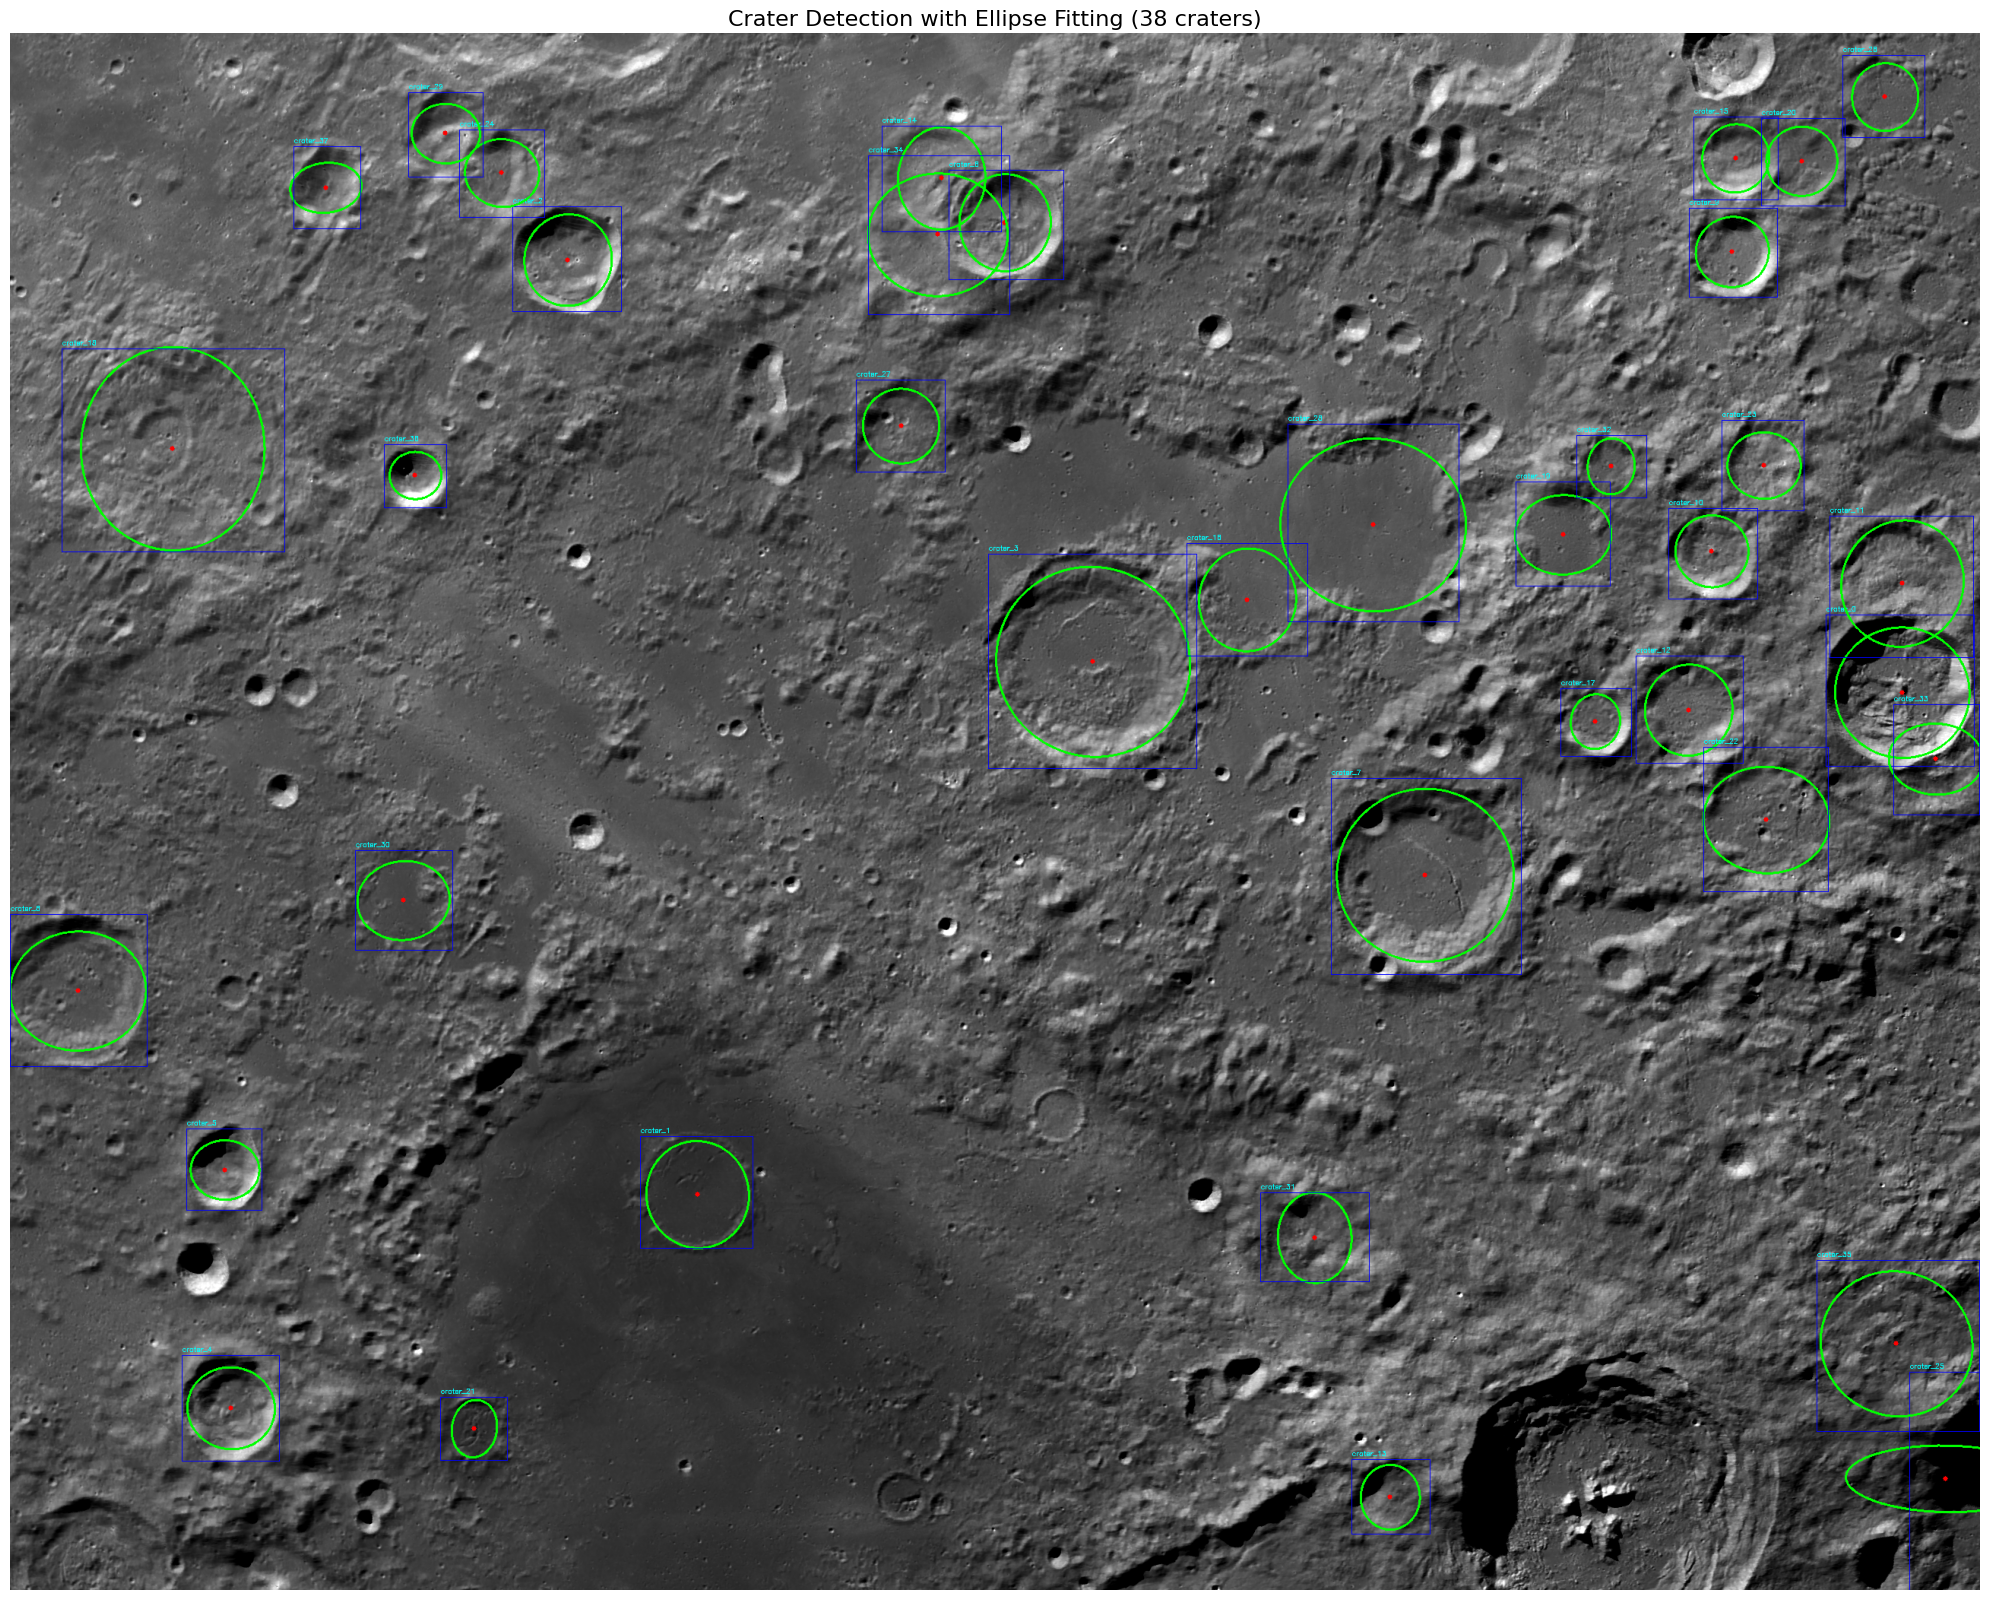


Pipeline completed successfully!
Total craters detected: 38
Ellipses fitted: 38
Output directory: D:\datashare\crater_detection_output\orientation01_light02


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ellipse parameters
df_ellipses = pd.read_csv(ellipse_csv_path)
print(f"Loaded {len(df_ellipses)} ellipse parameters")

# Create overlay on original image
overlay = original_img.copy()

for idx, row in df_ellipses.iterrows():
    # Get crop coordinates in original image
    bbox_x1 = int(row['bbox_x1'])
    bbox_y1 = int(row['bbox_y1'])
    bbox_x2 = int(row['bbox_x2'])
    bbox_y2 = int(row['bbox_y2'])
    
    # Ellipse parameters in crop coordinates
    cx_crop = row['center_x_crop']
    cy_crop = row['center_y_crop']
    semi_major = row['semi_major']
    semi_minor = row['semi_minor']
    angle = row['angle_deg']
    
    # Transform to original image coordinates
    cx_original = bbox_x1 + cx_crop
    cy_original = bbox_y1 + cy_crop
    
    # Draw ellipse on original image
    ellipse = (
        (float(cx_original), float(cy_original)),
        (float(semi_major * 2), float(semi_minor * 2)),  # Full axes
        float(angle)
    )
    
    # Draw ellipse (green)
    cv2.ellipse(overlay, ellipse, (0, 255, 0), 2)
    
    # Draw center point (red)
    cv2.circle(overlay, (int(cx_original), int(cy_original)), 3, (0, 0, 255), -1)
    
    # Draw bounding box (blue) to verify alignment
    cv2.rectangle(overlay, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), (255, 0, 0), 1)
    
    # Add crater ID label
    cv2.putText(overlay, f"crater_{row['crater_id']}", 
                (bbox_x1, bbox_y1 - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)

# Save final overlay
final_output_path = os.path.join(results_dir, "final_ellipses_overlay.jpg")
cv2.imwrite(final_output_path, overlay)
print(f"\nFinal overlay saved to: {final_output_path}")

# Display result
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Crater Detection with Ellipse Fitting ({len(df_ellipses)} craters)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Pipeline completed successfully!")
print(f"{'='*60}")
print(f"Total craters detected: {len(detections)}")
print(f"Ellipses fitted: {len(df_ellipses)}")
print(f"Output directory: {output_dir}")
print(f"{'='*60}")

### Step 5: Verification - Show Individual Crops with Ellipses

Individual crop visualizations saved to: D:\datashare\crater_detection_output\orientation01_light02\visualizations


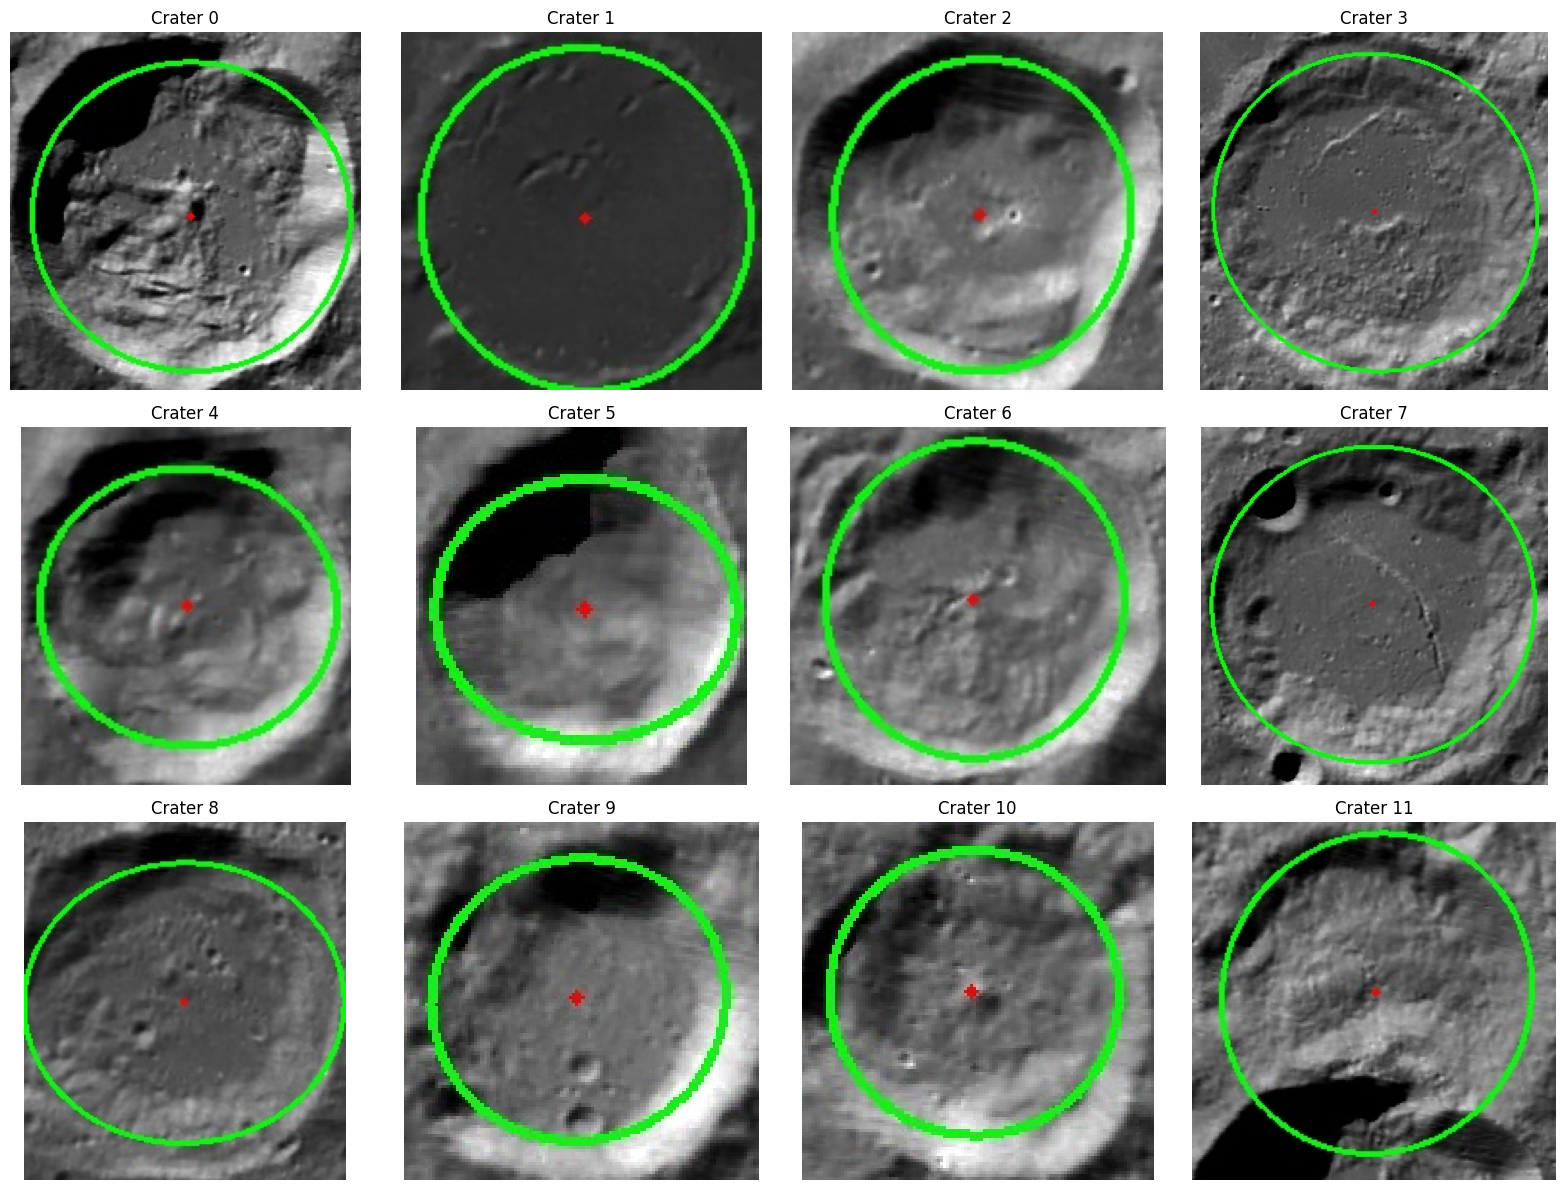

In [5]:
# Create visualization directory
viz_dir = os.path.join(output_dir, "visualizations")
os.makedirs(viz_dir, exist_ok=True)

# Generate visualization for each crop
for idx, row in df_ellipses.iterrows():
    crop_path = os.path.join(crops_dir, row['crop_file'])
    crop_img = cv2.imread(crop_path)
    
    if crop_img is None:
        continue
    
    # Draw ellipse on crop
    ellipse_crop = (
        (float(row['center_x_crop']), float(row['center_y_crop'])),
        (float(row['semi_major'] * 2), float(row['semi_minor'] * 2)),
        float(row['angle_deg'])
    )
    
    cv2.ellipse(crop_img, ellipse_crop, (0, 255, 0), 2)
    cv2.circle(crop_img, 
               (int(row['center_x_crop']), int(row['center_y_crop'])), 
               2, (0, 0, 255), -1)
    
    # Save visualization
    viz_path = os.path.join(viz_dir, f"crater_{row['crater_id']:03d}_ellipse.jpg")
    cv2.imwrite(viz_path, crop_img)

print(f"Individual crop visualizations saved to: {viz_dir}")

# Display grid of first 12 crops
n_display = min(12, len(df_ellipses))
cols = 4
rows = (n_display + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))

for i in range(n_display):
    row = df_ellipses.iloc[i]
    viz_path = os.path.join(viz_dir, f"crater_{row['crater_id']:03d}_ellipse.jpg")
    img = cv2.imread(viz_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Crater {row['crater_id']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 6: Export Summary Statistics

In [6]:
# Calculate statistics
stats = {
    'total_detections': len(detections),
    'successful_ellipse_fits': len(df_ellipses),
    'fit_success_rate': f"{(len(df_ellipses)/len(detections)*100):.1f}%",
    'avg_semi_major': f"{df_ellipses['semi_major'].mean():.2f}",
    'avg_semi_minor': f"{df_ellipses['semi_minor'].mean():.2f}",
    'avg_eccentricity': f"{(1 - (df_ellipses['semi_minor']/df_ellipses['semi_major'])**2).mean():.3f}",
    'min_crater_size': f"{df_ellipses['semi_major'].min():.2f}",
    'max_crater_size': f"{df_ellipses['semi_major'].max():.2f}"
}

# Save statistics
stats_path = os.path.join(results_dir, "summary_statistics.json")
with open(stats_path, 'w') as f:
    json.dump(stats, f, indent=2)

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
for key, value in stats.items():
    print(f"{key.replace('_', ' ').title():.<40} {value}")
print("="*60)

print(f"\nStatistics saved to: {stats_path}")


SUMMARY STATISTICS
Total Detections........................ 38
Successful Ellipse Fits................. 38
Fit Success Rate........................ 100.0%
Avg Semi Major.......................... 67.60
Avg Semi Minor.......................... 59.49
Avg Eccentricity........................ 0.197
Min Crater Size......................... 34.04
Max Crater Size......................... 133.74

Statistics saved to: D:\datashare\crater_detection_output\orientation01_light02\results\summary_statistics.json
